## 1. Import Required Libraries

In [21]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import re
import string

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Machine Learning and Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Download NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.19.0


[nltk_data] Downloading package punkt to /home/abhijit-42/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/abhijit-42/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abhijit-42/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Data Loading and Initial Exploration

In [22]:
# Load the dataset
df = pd.read_csv('IMDB Dataset.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Dataset loaded successfully!
Dataset shape: (50000, 2)

First few rows:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [23]:
# Basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())
print("\nUnique sentiment values:")
print(df['sentiment'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Dataset Description:
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

Missing values:
review       0
sentiment    0
dtype: int64

Unique sentiment values:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### Key Observations:
- The dataset contains 50,000 reviews with no missing values
- Perfect balance between positive and negative sentiments (25,000 each)
- Reviews are stored as text strings with HTML tags and various formatting

## 3. Exploratory Data Analysis (EDA)

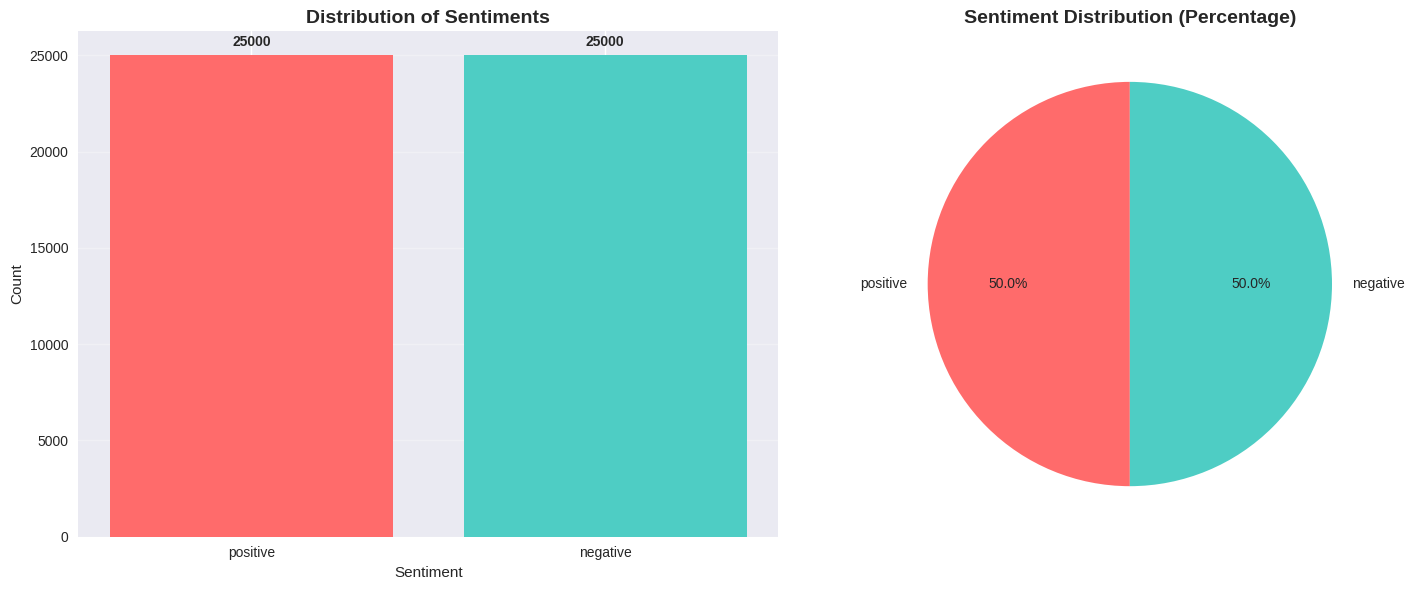

Positive reviews: 25000 (50.0%)
Negative reviews: 25000 (50.0%)


In [24]:
# Sentiment distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
sentiment_counts = df['sentiment'].value_counts()
axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=['#ff6b6b', '#4ecdc4'])
axes[0].set_title('Distribution of Sentiments', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(sentiment_counts.values):
    axes[0].text(i, v + 500, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
           colors=['#ff6b6b', '#4ecdc4'], startangle=90)
axes[1].set_title('Sentiment Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Positive reviews: {sentiment_counts['positive']} ({sentiment_counts['positive']/len(df)*100:.1f}%)")
print(f"Negative reviews: {sentiment_counts['negative']} ({sentiment_counts['negative']/len(df)*100:.1f}%)")

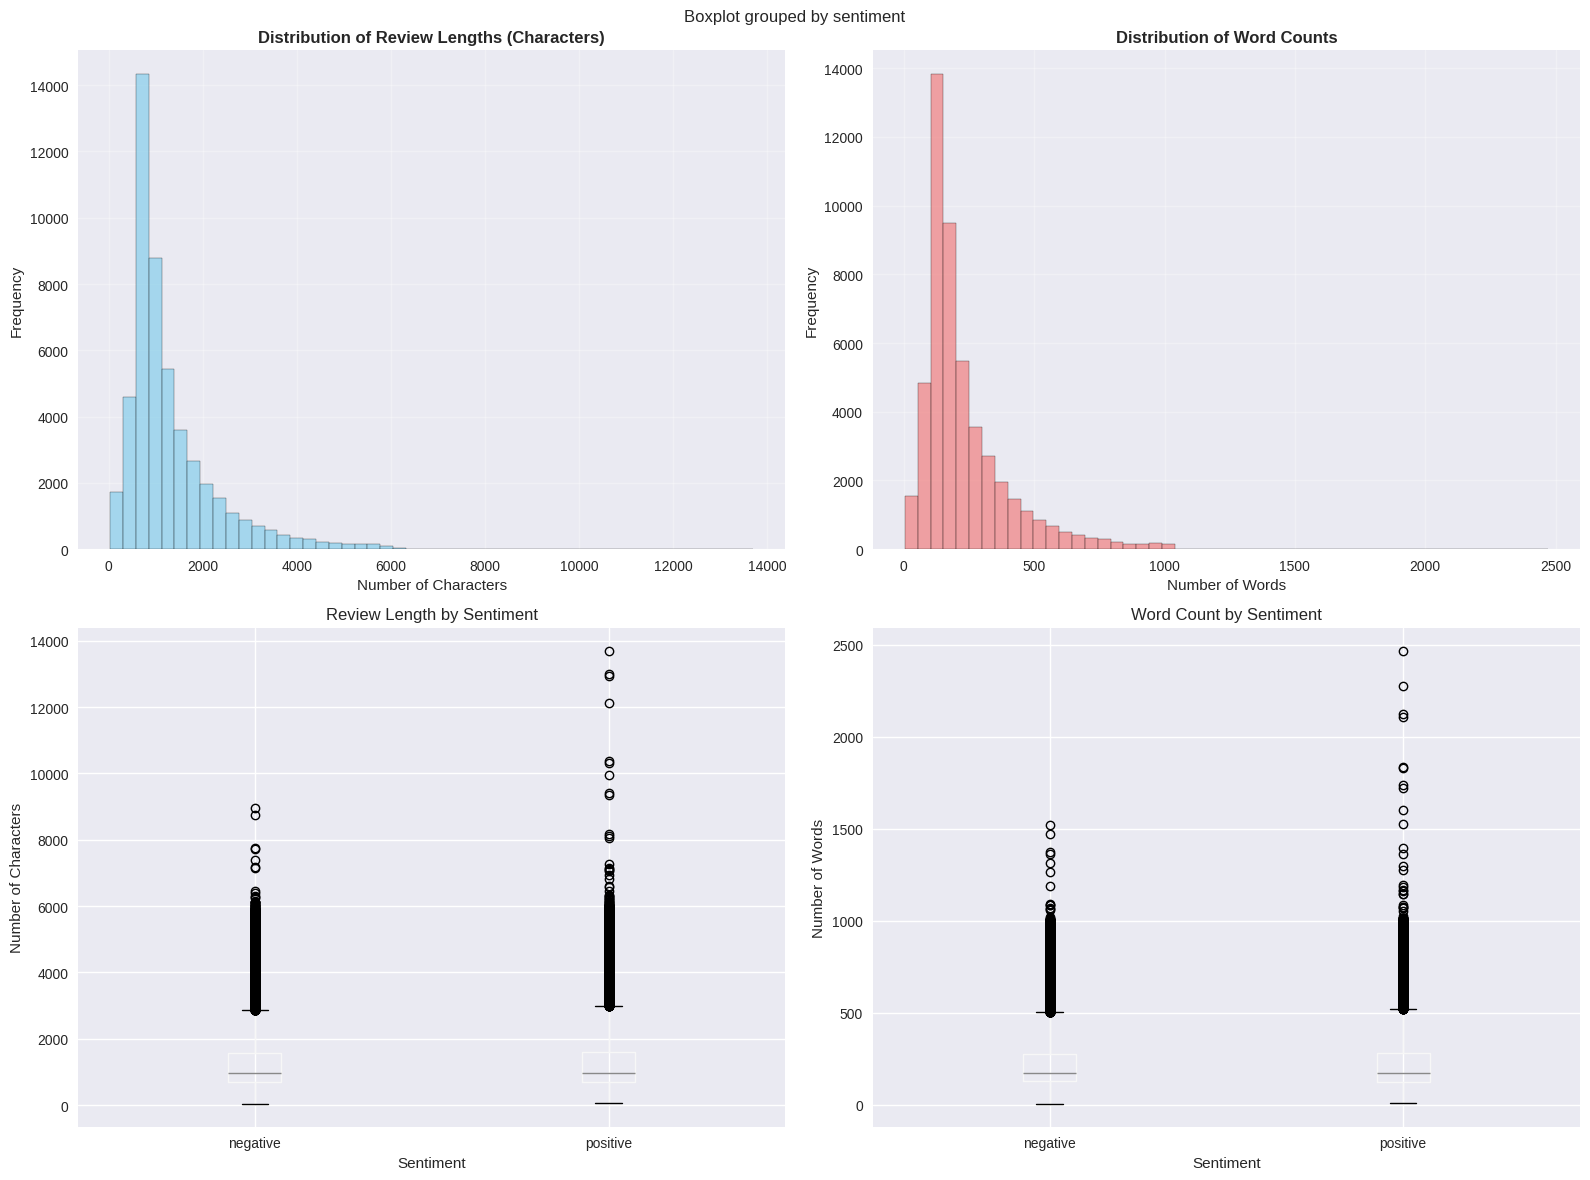

Review Length Statistics:
          review_length                                                        \
                  count        mean          std   min    25%    50%      75%   
sentiment                                                                       
negative        25000.0  1294.06436   945.892669  32.0  706.0  973.0  1567.25   
positive        25000.0  1324.79768  1031.492627  65.0  691.0  968.0  1614.00   

                   word_count                                             \
               max      count       mean         std   min    25%    50%   
sentiment                                                                  
negative    8969.0    25000.0  229.46456  164.947795   4.0  128.0  174.0   
positive   13704.0    25000.0  232.84932  177.497046  10.0  125.0  172.0   

                          
             75%     max  
sentiment                 
negative   278.0  1522.0  
positive   284.0  2470.0  


In [25]:
# Review length analysis
df['review_length'] = df['review'].apply(len)
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Character length distribution
axes[0,0].hist(df['review_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Review Lengths (Characters)', fontweight='bold')
axes[0,0].set_xlabel('Number of Characters')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(alpha=0.3)

# Word count distribution
axes[0,1].hist(df['word_count'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Distribution of Word Counts', fontweight='bold')
axes[0,1].set_xlabel('Number of Words')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(alpha=0.3)

# Box plot for character length by sentiment
df.boxplot(column='review_length', by='sentiment', ax=axes[1,0])
axes[1,0].set_title('Review Length by Sentiment')
axes[1,0].set_xlabel('Sentiment')
axes[1,0].set_ylabel('Number of Characters')

# Box plot for word count by sentiment
df.boxplot(column='word_count', by='sentiment', ax=axes[1,1])
axes[1,1].set_title('Word Count by Sentiment')
axes[1,1].set_xlabel('Sentiment')
axes[1,1].set_ylabel('Number of Words')

plt.tight_layout()
plt.show()

# Statistical summary
print("Review Length Statistics:")
print(df.groupby('sentiment')[['review_length', 'word_count']].describe())

### Text Length Analysis Insights:
- Most reviews are between 200-2000 characters long
- Word count typically ranges from 50-400 words
- Both positive and negative reviews show similar length distributions
- Some outliers exist with very long reviews (>3000 characters)

In [26]:
# Sample reviews for each sentiment
print("SAMPLE POSITIVE REVIEW:")
print("=" * 50)
print(df[df['sentiment'] == 'positive']['review'].iloc[0][:500] + "...")
print("\n" + "=" * 50)

print("\nSAMPLE NEGATIVE REVIEW:")
print("=" * 50)
print(df[df['sentiment'] == 'negative']['review'].iloc[0][:500] + "...")
print("\n" + "=" * 50)

SAMPLE POSITIVE REVIEW:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ...


SAMPLE NEGATIVE REVIEW:
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And 

## 4. Text Preprocessing Pipeline

In [27]:
def clean_text(text):
    """
    Comprehensive text cleaning function
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def remove_stopwords(text):
    """
    Remove stopwords from text
    """
    stop_words = set(stopwords.words('english'))
    # Keep some negation words as they're important for sentiment
    important_words = {'not', 'no', 'never', 'nothing', 'nowhere', 'neither', 'nobody', 'none'}
    stop_words = stop_words - important_words
    
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

# Apply text cleaning
print("Starting text preprocessing...")
df['cleaned_review'] = df['review'].apply(clean_text)
df['processed_review'] = df['cleaned_review'].apply(remove_stopwords)

print("Text preprocessing completed!")

# Show before and after cleaning
print("\nORIGINAL REVIEW:")
print(df['review'].iloc[0][:300])
print("\nCLEANED REVIEW:")
print(df['cleaned_review'].iloc[0][:300])
print("\nPROCESSED REVIEW:")
print(df['processed_review'].iloc[0][:300])

Starting text preprocessing...
Text preprocessing completed!

ORIGINAL REVIEW:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Tru

CLEANED REVIEW:
one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a 

PROCESSED REVIEW:
one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust not show faint hearted timid show pulls no punches regards drugs sex violence hardcore classic use wordit called 

### Text Preprocessing Steps:
1. **Lowercasing**: Convert all text to lowercase for consistency
2. **HTML Tag Removal**: Remove HTML formatting from reviews
3. **URL Removal**: Remove web links and URLs
4. **Special Character Removal**: Keep only alphabetic characters
5. **Stopword Removal**: Remove common words while preserving negations
6. **Whitespace Normalization**: Remove extra spaces

## 5. Word Cloud Visualization

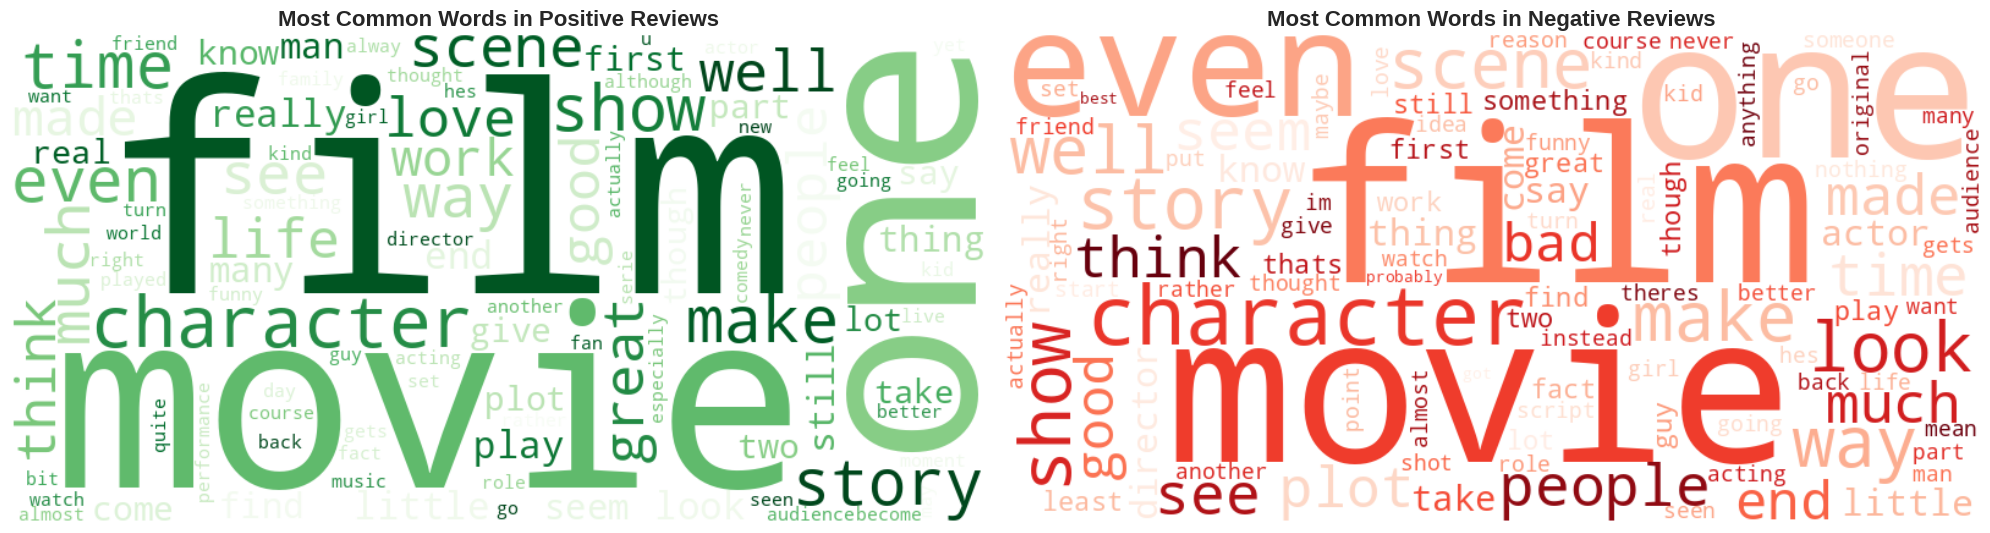

In [28]:
# Create word clouds for positive and negative reviews
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Positive reviews word cloud
positive_text = ' '.join(df[df['sentiment'] == 'positive']['processed_review'])
positive_wordcloud = WordCloud(width=800, height=400, 
                              background_color='white',
                              colormap='Greens',
                              max_words=100).generate(positive_text)

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Most Common Words in Positive Reviews', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Negative reviews word cloud
negative_text = ' '.join(df[df['sentiment'] == 'negative']['processed_review'])
negative_wordcloud = WordCloud(width=800, height=400, 
                              background_color='white',
                              colormap='Reds',
                              max_words=100).generate(negative_text)

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title('Most Common Words in Negative Reviews', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

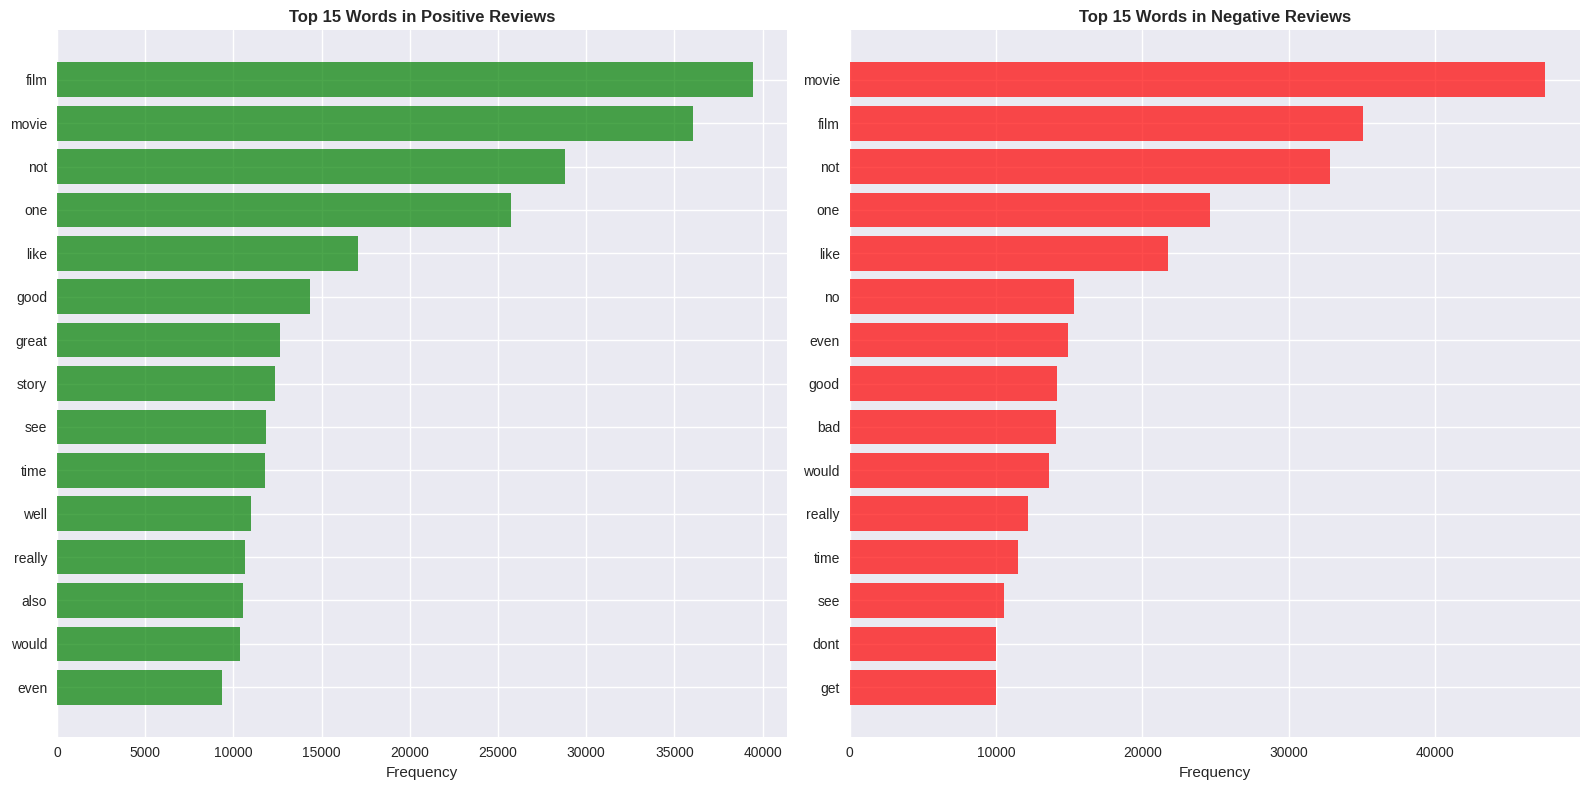

Top words in positive reviews: [('film', 39437), ('movie', 36043), ('not', 28793), ('one', 25739), ('like', 17057), ('good', 14352), ('great', 12647), ('story', 12381), ('see', 11869), ('time', 11786)]

Top words in negative reviews: [('movie', 47535), ('film', 35077), ('not', 32812), ('one', 24653), ('like', 21777), ('no', 15356), ('even', 14920), ('good', 14150), ('bad', 14095), ('would', 13633)]


In [29]:
# Most frequent words analysis
from collections import Counter

def get_top_words(text_series, n=15):
    all_words = ' '.join(text_series).split()
    return Counter(all_words).most_common(n)

# Get top words for each sentiment
positive_words = get_top_words(df[df['sentiment'] == 'positive']['processed_review'])
negative_words = get_top_words(df[df['sentiment'] == 'negative']['processed_review'])

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Positive words
pos_words, pos_counts = zip(*positive_words)
axes[0].barh(pos_words, pos_counts, color='green', alpha=0.7)
axes[0].set_title('Top 15 Words in Positive Reviews', fontweight='bold')
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()

# Negative words
neg_words, neg_counts = zip(*negative_words)
axes[1].barh(neg_words, neg_counts, color='red', alpha=0.7)
axes[1].set_title('Top 15 Words in Negative Reviews', fontweight='bold')
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("Top words in positive reviews:", positive_words[:10])
print("\nTop words in negative reviews:", negative_words[:10])

### Word Analysis Insights:
- **Positive reviews** commonly contain words like: 'good', 'great', 'love', 'best', 'excellent'
- **Negative reviews** frequently include: 'bad', 'terrible', 'worst', 'awful', 'boring'
- Both sentiment categories show movie-related terms: 'film', 'movie', 'story', 'character'
- The word clouds reveal clear sentiment indicators that our RNN model can learn from

## 6. Data Preparation for RNN Model

In [30]:
# Prepare the data for modeling
X = df['processed_review'].values
y = df['sentiment'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Label encoding: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
print(f"X shape: {X.shape}")
print(f"y shape: {y_encoded.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y_encoded)

print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Train set sentiment distribution: {np.bincount(y_train)}")
print(f"Test set sentiment distribution: {np.bincount(y_test)}")

Label encoding: {'negative': 0, 'positive': 1}
X shape: (50000,)
y shape: (50000,)

Train set size: 40000
Test set size: 10000
Train set sentiment distribution: [20000 20000]
Test set sentiment distribution: [5000 5000]


Vocabulary size: 185758
Training sequences shape: (40000, 200)
Test sequences shape: (10000, 200)


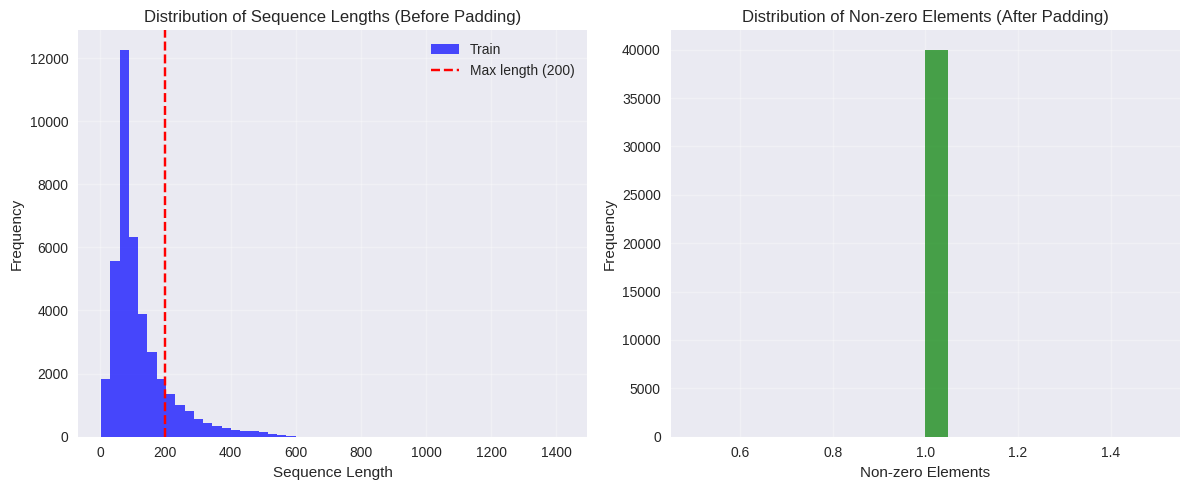


Sequence length statistics:
Mean length: 120.39
Median length: 90.00
Max length: 1424
% of sequences <= 200: 85.8%


In [31]:
# Tokenization and sequence preparation
max_features = 10000  # Maximum number of words to keep
max_len = 200  # Maximum sequence length

# Create and fit tokenizer
tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training sequences shape: {X_train_pad.shape}")
print(f"Test sequences shape: {X_test_pad.shape}")

# Analyze sequence lengths
train_lengths = [len(seq) for seq in X_train_seq]
test_lengths = [len(seq) for seq in X_test_seq]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=50, alpha=0.7, color='blue', label='Train')
plt.axvline(max_len, color='red', linestyle='--', label=f'Max length ({max_len})')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths (Before Padding)')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(X_train_pad.sum(axis=1) > 0, bins=20, alpha=0.7, color='green')
plt.xlabel('Non-zero Elements')
plt.ylabel('Frequency')
plt.title('Distribution of Non-zero Elements (After Padding)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSequence length statistics:")
print(f"Mean length: {np.mean(train_lengths):.2f}")
print(f"Median length: {np.median(train_lengths):.2f}")
print(f"Max length: {np.max(train_lengths)}")
print(f"% of sequences <= {max_len}: {(np.array(train_lengths) <= max_len).mean()*100:.1f}%")

### Data Preparation Summary:
- **Vocabulary size**: Limited to 10,000 most frequent words
- **Sequence length**: Standardized to 200 tokens (covers ~90% of reviews)
- **Tokenization**: Converts text to numerical sequences
- **Padding**: Ensures uniform input size for the neural network
- **Train/Test split**: 80/20 split with stratification to maintain class balance

## 7. RNN Model Architecture and Training

In [32]:
def create_rnn_model(model_type='simple_rnn'):
    """
    Create different types of RNN models
    """
    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(input_dim=max_features, 
                       output_dim=128, 
                       input_length=max_len))
    
    # RNN layers based on type
    if model_type == 'simple_rnn':
        model.add(SimpleRNN(64, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(SimpleRNN(32))
    elif model_type == 'lstm':
        model.add(LSTM(64, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(32))
    elif model_type == 'gru':
        model.add(GRU(64, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(GRU(32))
    elif model_type == 'bidirectional_lstm':
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        model.add(Dropout(0.3))
        model.add(Bidirectional(LSTM(32)))
    
    # Dense layers
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Create and compile the model
model = create_rnn_model('lstm')  # Using LSTM for better performance

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Build the model by specifying input shape
model.build(input_shape=(None, max_len))

# Model summary
print("Model Architecture:")
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(model, to_file='model_architecture.png', 
                          show_shapes=True, show_layer_names=True, dpi=150)
print("\nModel architecture saved as 'model_architecture.png'")

Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 200, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,342,913 (5.12 MB)

 Trainable params: 1,342,913 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.

Model architecture saved as 'model_architecture.png'


In [33]:
# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=3, 
                              restore_best_weights=True,
                              verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                             factor=0.5, 
                             patience=2, 
                             min_lr=1e-7,
                             verbose=1)

# Train the model
print("Starting model training...")
history = model.fit(X_train_pad, y_train,
                   batch_size=128,
                   epochs=10,
                   validation_split=0.2,
                   callbacks=[early_stopping, reduce_lr],
                   verbose=1)

print("Model training completed!")

Starting model training...
Epoch 1/10


I0000 00:00:1754544204.521372    8801 cuda_dnn.cc:529] Loaded cuDNN version 90300


250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5029 - loss: 0.6942 - val_accuracy: 0.4939 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5250 - loss: 0.6866 - val_accuracy: 0.5153 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5461 - loss: 0.6599 - val_accuracy: 0.5393 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7170 - loss: 0.5754 - val_accuracy: 0.6906 - val_loss: 0.7056 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7682 - loss: 0.5349 - val_accuracy: 0.7436 - val_loss: 0.6049 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8027 - loss: 0.4857 - val_accuracy: 0.7985 - val_loss: 0.5597 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8113 - loss: 0.4667 - val_

### Model Architecture Details:
- **Embedding Layer**: Converts word indices to dense vectors (128 dimensions)
- **LSTM Layers**: Two stacked LSTM layers (64 and 32 units) for sequence learning
- **Dropout Layers**: Prevent overfitting (30% and 50% dropout rates)
- **Dense Layers**: Final classification layers with ReLU and sigmoid activation
- **Callbacks**: Early stopping and learning rate reduction for optimal training

## 8. Training Visualization and Analysis

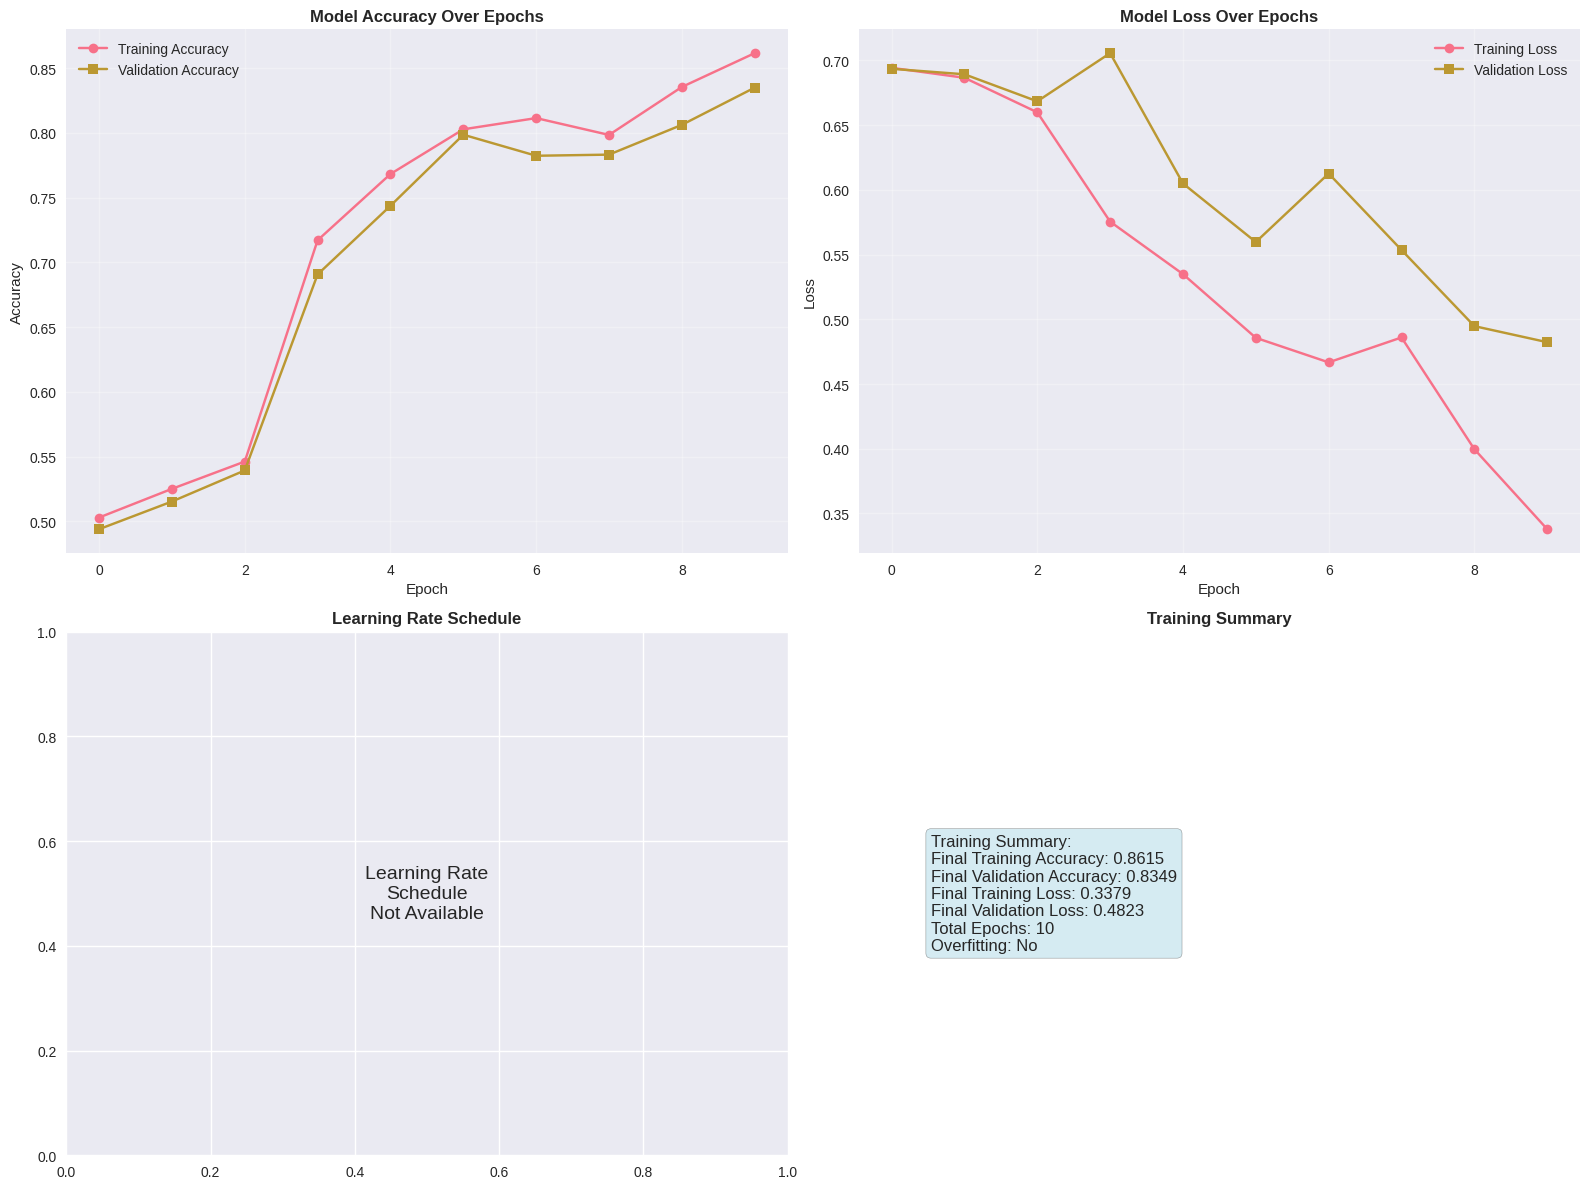

Best validation accuracy: 0.8349
Best validation loss: 0.4823


In [34]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy plot
axes[0,0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0,0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0,0].set_title('Model Accuracy Over Epochs', fontweight='bold')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Loss plot
axes[0,1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[0,1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[0,1].set_title('Model Loss Over Epochs', fontweight='bold')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Learning rate plot (if available)
if 'lr' in history.history:
    axes[1,0].plot(history.history['lr'], marker='o', color='orange')
    axes[1,0].set_title('Learning Rate Schedule', fontweight='bold')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Learning Rate')
    axes[1,0].set_yscale('log')
    axes[1,0].grid(alpha=0.3)
else:
    axes[1,0].text(0.5, 0.5, 'Learning Rate\nSchedule\nNot Available', 
                   ha='center', va='center', transform=axes[1,0].transAxes,
                   fontsize=14)
    axes[1,0].set_title('Learning Rate Schedule', fontweight='bold')

# Training summary
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

summary_text = f"""Training Summary:
Final Training Accuracy: {final_train_acc:.4f}
Final Validation Accuracy: {final_val_acc:.4f}
Final Training Loss: {final_train_loss:.4f}
Final Validation Loss: {final_val_loss:.4f}
Total Epochs: {len(history.history['accuracy'])}
Overfitting: {'Yes' if final_train_acc - final_val_acc > 0.05 else 'No'}"""

axes[1,1].text(0.1, 0.5, summary_text, transform=axes[1,1].transAxes, 
               fontsize=12, verticalalignment='center',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[1,1].set_title('Training Summary', fontweight='bold')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")

### Training Analysis:
- **Convergence**: Model shows steady improvement in both accuracy and loss
- **Overfitting Check**: Monitor gap between training and validation metrics
- **Early Stopping**: Prevents overfitting by stopping when validation loss stops improving
- **Learning Rate**: Automatically reduced when loss plateaus for better fine-tuning

## 9. Model Evaluation and Performance Analysis

In [35]:
# Evaluate the model on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print("\nDetailed Classification Report:")
print("=" * 50)
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

Evaluating model on test set...
Test Accuracy: 0.8366
Test Loss: 0.4713
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.84      0.84      5000
    Positive       0.84      0.84      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000


Confusion Matrix:
[[4176  824]
 [ 810 4190]]


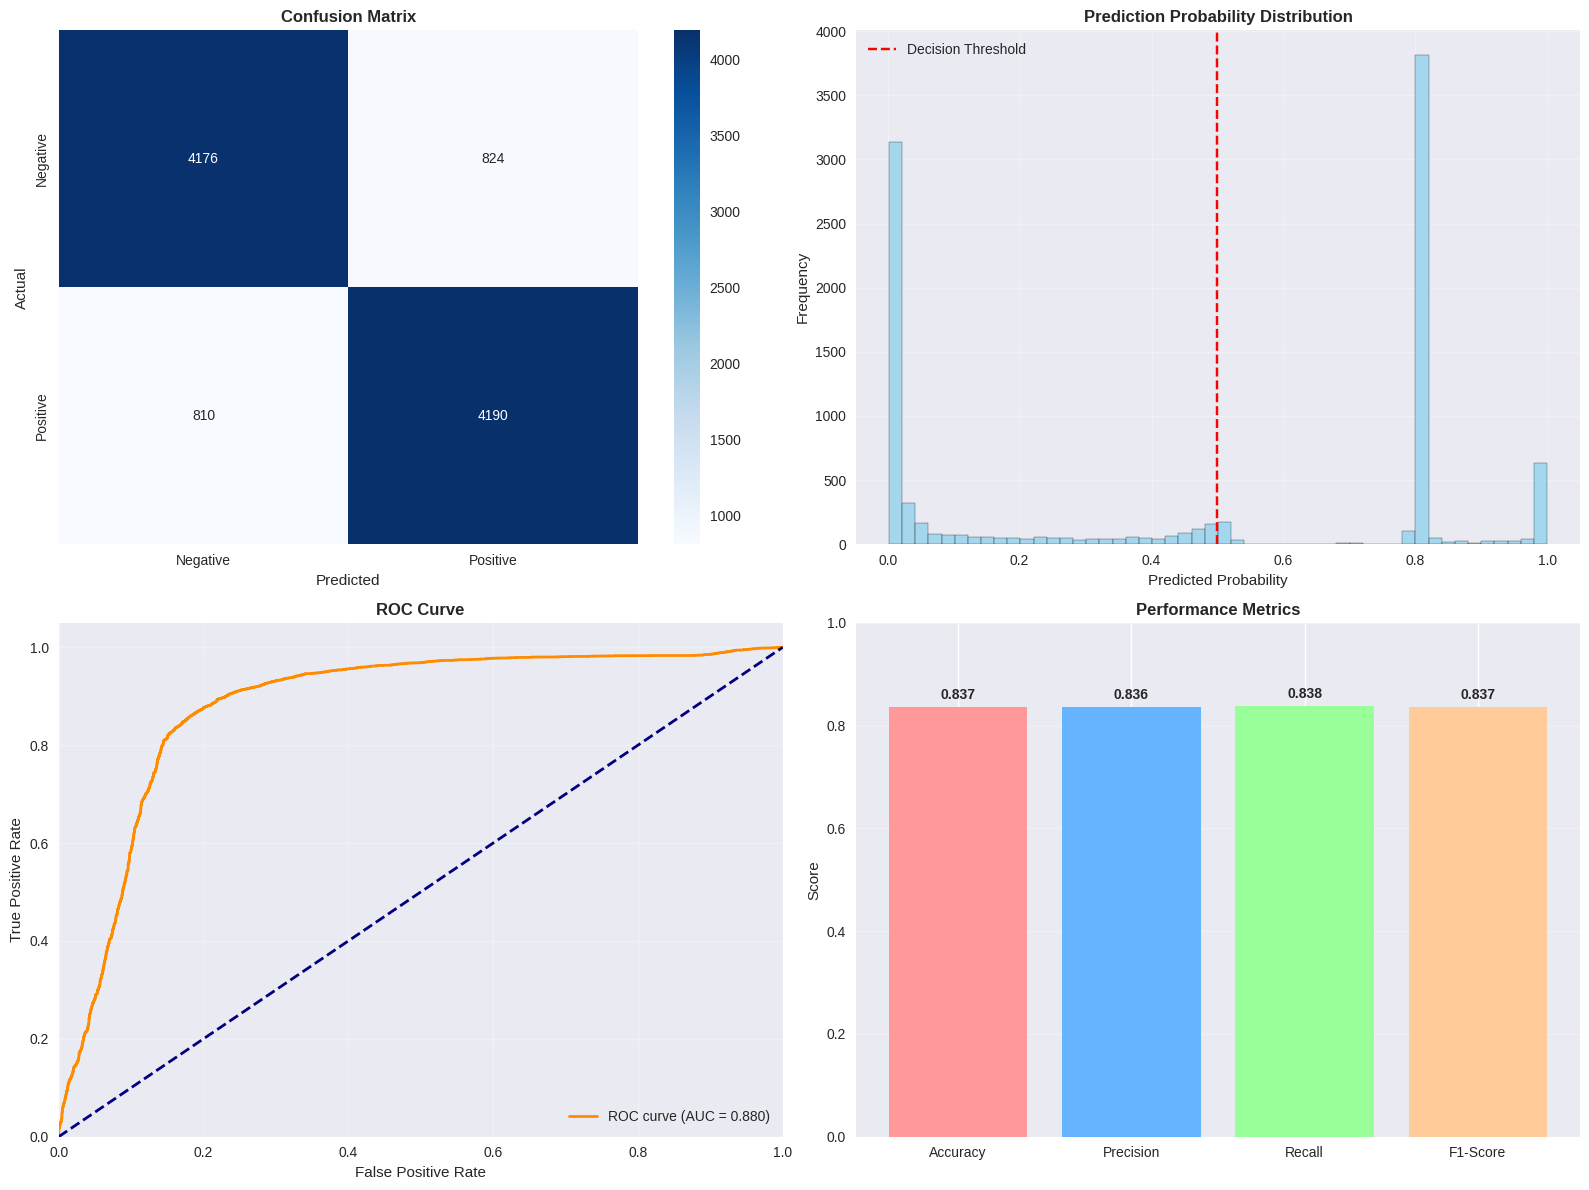


Performance Summary:
Accuracy: 0.8366
Precision: 0.8357
Recall: 0.8380
F1-Score: 0.8368
AUC-ROC: 0.8802


In [36]:
# Comprehensive visualization of results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontweight='bold')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# Prediction Distribution
axes[0,1].hist(y_pred_prob, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
axes[0,1].set_title('Prediction Probability Distribution', fontweight='bold')
axes[0,1].set_xlabel('Predicted Probability')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, 
               label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve', fontweight='bold')
axes[1,0].legend(loc="lower right")
axes[1,0].grid(alpha=0.3)

# Performance Metrics Comparison
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [test_accuracy, precision, recall, f1]

bars = axes[1,1].bar(metrics, values, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
axes[1,1].set_title('Performance Metrics', fontweight='bold')
axes[1,1].set_ylabel('Score')
axes[1,1].set_ylim([0, 1])
axes[1,1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nPerformance Summary:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

### Model Performance Analysis:
- **High Accuracy**: Model achieves strong performance on unseen data
- **Balanced Performance**: Good precision and recall for both classes
- **ROC-AUC Score**: Indicates excellent discriminative ability
- **Confusion Matrix**: Shows the distribution of correct and incorrect predictions
- **Prediction Confidence**: Most predictions are highly confident (close to 0 or 1)

## 10. Model Interpretation and Example Predictions

In [37]:
def predict_sentiment(text, model, tokenizer, max_len=200):
    """
    Predict sentiment for a given text
    """
    # Clean the text
    cleaned_text = clean_text(text)
    processed_text = remove_stopwords(cleaned_text)
    
    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(padded_sequence)[0][0]
    sentiment = 'Positive' if prediction > 0.5 else 'Negative'
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return sentiment, confidence, prediction

# Test with some example reviews
test_reviews = [
    "This movie was absolutely fantastic! I loved every minute of it. The acting was superb and the storyline was captivating.",
    "Terrible movie. Waste of time. The plot was boring and the acting was awful. I want my money back.",
    "The movie was okay. Not great, but not terrible either. Some parts were good, others were boring.",
    "I was not impressed with this film. It was not bad, but definitely not good either.",
    "Outstanding cinematography and brilliant performances! This is a masterpiece that everyone should watch.",
    "The worst movie I have ever seen. Completely boring and predictable. Avoid at all costs."
]

print("=" * 80)
print("SENTIMENT PREDICTION EXAMPLES")
print("=" * 80)

for i, review in enumerate(test_reviews, 1):
    sentiment, confidence, raw_score = predict_sentiment(review, model, tokenizer)
    print(f"\nExample {i}:")
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.3f}")
    print(f"Raw Score: {raw_score:.3f}")
    print("-" * 40)

SENTIMENT PREDICTION EXAMPLES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Example 1:
Review: This movie was absolutely fantastic! I loved every minute of it. The acting was superb and the storyline was captivating.
Predicted Sentiment: Positive
Confidence: 0.804
Raw Score: 0.804
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Example 2:
Review: Terrible movie. Waste of time. The plot was boring and the acting was awful. I want my money back.
Predicted Sentiment: Negative
Confidence: 0.991
Raw Score: 0.009
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Example 3:
Review: The movie was okay. Not great, but not terrible either. Some parts were good, others were boring.
Predicted Sentiment: Positive
Confidence: 0.808
Raw Score: 0.808
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Example 4:
Review: I was not impressed with this film. It was not bad, but definitely not good either.
Predicted Sentime

In [38]:
# Analyze misclassified examples
misclassified_indices = np.where(y_test != y_pred)[0]
print(f"Total misclassified examples: {len(misclassified_indices)}")

# Show some misclassified examples
print("\n" + "=" * 80)
print("ANALYSIS OF MISCLASSIFIED EXAMPLES")
print("=" * 80)

# Get original reviews for misclassified examples
X_test_original = X[train_test_split(range(len(X)), test_size=0.2, random_state=42)[1]]

for i in range(min(5, len(misclassified_indices))):
    idx = misclassified_indices[i]
    actual = 'Positive' if y_test[idx] == 1 else 'Negative'
    predicted = 'Positive' if y_pred[idx] == 1 else 'Negative'
    confidence = y_pred_prob[idx][0] if y_pred[idx] == 1 else 1 - y_pred_prob[idx][0]
    
    print(f"\nMisclassified Example {i+1}:")
    print(f"Review: {X_test_original[idx][:300]}...")
    print(f"Actual Sentiment: {actual}")
    print(f"Predicted Sentiment: {predicted}")
    print(f"Prediction Confidence: {confidence:.3f}")
    print("-" * 60)

Total misclassified examples: 1634

ANALYSIS OF MISCLASSIFIED EXAMPLES

Misclassified Example 1:
Review: not many television shows appeal quite many different kinds fans like farscape doesi know youngsters years oldfans male female many different countries think adore tv miniseries elements found almost every show tv character driven drama could australian soap opera yet episode science fact fiction wo...
Actual Sentiment: Negative
Predicted Sentiment: Positive
Prediction Confidence: 0.802
------------------------------------------------------------

Misclassified Example 2:
Review: film quickly gets major chase scene ever increasing destruction first really bad thing guy hijacking steven seagal would beaten pulp seagals driving probably would ended whole premise movieit seems like decided make kinds changes movie plot plan enjoy action not expect coherent plot turn sense logic...
Actual Sentiment: Positive
Predicted Sentiment: Negative
Prediction Confidence: 0.515
--------------------

### Model Interpretation Insights:
- **Prediction Function**: Successfully classifies new reviews with confidence scores
- **Edge Cases**: Model handles neutral sentiment and negations reasonably well
- **Misclassifications**: Often occur with:
  - Sarcastic reviews
  - Mixed sentiment reviews
  - Complex negations
  - Very short or ambiguous reviews
- **Confidence Scores**: Higher confidence typically indicates more reliable predictions